In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as pltgrid
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score
from imblearn.over_sampling import SMOTENC

from scipy.stats.contingency import association

C:\Users\RamS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Exploration

In [3]:
data = pd.read_excel('Creators_case_study_sample_data.xlsx', sheet_name='Data')

In [4]:
data.head(5)

,CID,Sex,Aged,Hasaspouse,Reliesuponsomeone,duration,Youtube TV,Multiple Screens,Music Service,Hasmorethan3Playlists,Followsmorethan5artists,Haslistenedtomorethan5audiobooks,TechSupport,Listens Podcast,Listens Music,subscription type,online invoice,monthly invoice,TotalCharges,At risk,type of payment
0,1,Male,0,No,No,34,Yes,No,Hulu Music,Yes,No,Yes,No,No,No,One year,No,56.95,1889.50,No,courier check
1,2,Male,0,No,No,2,Yes,No,Hulu Music,Yes,Yes,No,No,No,No,Month-to-month,Yes,53.85,108.15,Yes,courier check
2,3,Female,0,No,No,2,Yes,No,Yotube Music,No,No,No,No,No,No,Month-to-month,Yes,70.70,151.65,Yes,echeck
3,4,Female,0,No,No,8,Yes,Yes,Yotube Music,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,99.65,820.50,Yes,echeck
4,5,Male,0,No,Yes,22,Yes,Yes,Yotube Music,No,Yes,No,No,Yes,No,Month-to-month,Yes,89.10,1949.40,No,cc


In [5]:
# isolate categorical and numerical features
cat_features = [
    'Sex', 'Aged', 'Hasaspouse', 'Reliesuponsomeone',
    'Youtube TV', 'Multiple Screens', 'Music Service',
    'Hasmorethan3Playlists', 'Followsmorethan5artists', 'Haslistenedtomorethan5audiobooks',
    'TechSupport', 'Listens Podcast', 'Listens Music', 'subscription type',
    'online invoice', 'type of payment'
]

num_features = ['duration', 'monthly invoice', 'TotalCharges']

features = cat_features + num_features

## Train-test split

In [6]:
# train-test split
train, test = train_test_split(
    data, test_size=0.20,
    random_state=1562,
    stratify=data['At risk'].apply(lambda x: 1 if x == 'Yes' else 0)
)

y_train = train['At risk'].apply(lambda x: 1 if x == 'Yes' else 0)
y_test = test['At risk'].apply(lambda x: 1 if x == 'Yes' else 0)

print(train.shape)
print(test.shape)

(3916, 21)
(979, 21)


In [7]:
# reset indexes
train = train.reset_index()
test = test.reset_index()

## Missing value treatment

We see that only 9 records in our training set are missing and only from one feature - TotalCharges. Only 0.2% of the total records of that feature are missing. While we can safely remove the records, let us look at the dsitribution of that feature and see what we can do in terms of imputation.

In [8]:
print(train.isnull().sum()[train.isnull().sum() > 0])
print(train.isnull().sum()[train.isnull().sum() > 0]/len(train)*100)

TotalCharges    9
dtype: int64
TotalCharges    0.229826
dtype: float64


We see that the feature is heavily right-skewed. Let us impute with median.

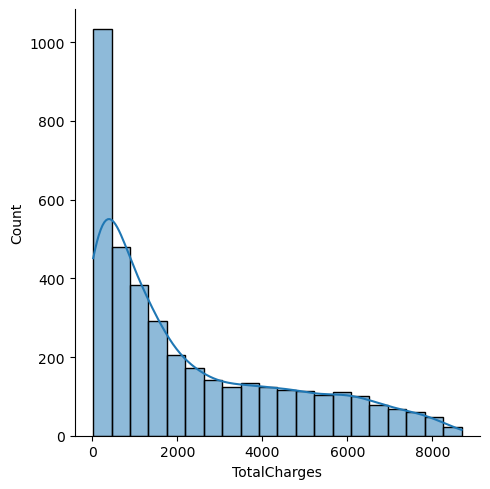

In [9]:
# checking the density plot
sns.displot(data=train, x='TotalCharges', kde=True)
plt.show()

In [10]:
# impute in both train and test (based on train)

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train['TotalCharges'] = imputer.fit_transform(np.array(train['TotalCharges']).reshape(-1, 1))
test['TotalCharges'] = imputer.transform(np.array(test['TotalCharges']).reshape(-1, 1))

## Exploring the features

#### Identify outliers in numerical features (univariate)

Let us use boxplots to see if there are any outliers in our dataset. We see that there are no outliers (usually marked separately outside the whiskers) in our numerical features.

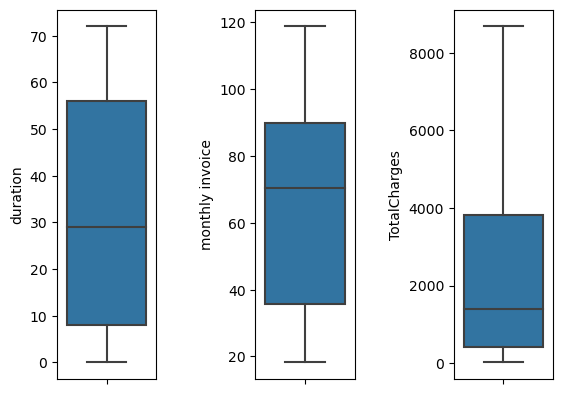

In [11]:
fig = plt.figure()
gs0 = pltgrid.GridSpec(1, 3, figure=fig, wspace=1)

ax1 = fig.add_subplot(gs0[0, 0])
ax2 = fig.add_subplot(gs0[0, 1])
ax3 = fig.add_subplot(gs0[0, 2])

sns.boxplot(data=train, y='duration', ax=ax1)
sns.boxplot(data=train, y='monthly invoice', ax=ax2)
sns.boxplot(data=train, y='TotalCharges', ax=ax3)

plt.show()

#### Exploring the cardinality of categorical features (univariate)

We see that most of the categorical features have 2-3 categories in them. We are going to use the Random Forest classifier which is resistant to the curse of dimensionality, so we do not have to worry about selecting features for our algorithm or trying to reduce dimensionality by clubbing together some categories in out categorical features.

In [12]:
cardinalities = []
cardinalities = [len(train[cat].unique()) for cat in cat_features]

temp_df = pd.DataFrame({'Cardinality':cardinalities, 'Feature':cat_features})

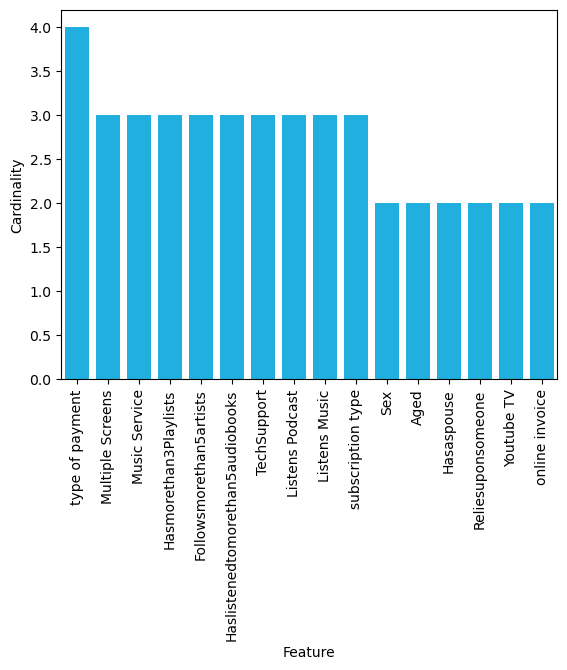

In [13]:
sns.barplot(x='Feature', y='Cardinality', data=temp_df, order=temp_df.sort_values('Cardinality', ascending=False)['Feature'], color='deepskyblue')
plt.xticks(rotation=90)
plt.show()

#### Association between binary response variable and categorical features (bivariate)

We use Cramer's V which is a measure of "correlation" between two categorical variables. It is a number bounded by 0 and 1 and stronger the correlation the more the value is closer to 1. 

We see from the plot below that none of the categorical variables are particularly strongly correlted with the response. However, it can be seen that the "subscription type" is the most strongly correlated categorical feature with the response.

##### We will drop the features with Cramer's V <= 0.20 before we build our Random Forest model

In [14]:
associations = []
for cat in cat_features:
    cont_table = pd.crosstab(index=train['At risk'], columns=train[cat])
    associations.append(association(cont_table, method='cramer'))

temp_df = pd.DataFrame({'Association':associations, 'Feature':cat_features})

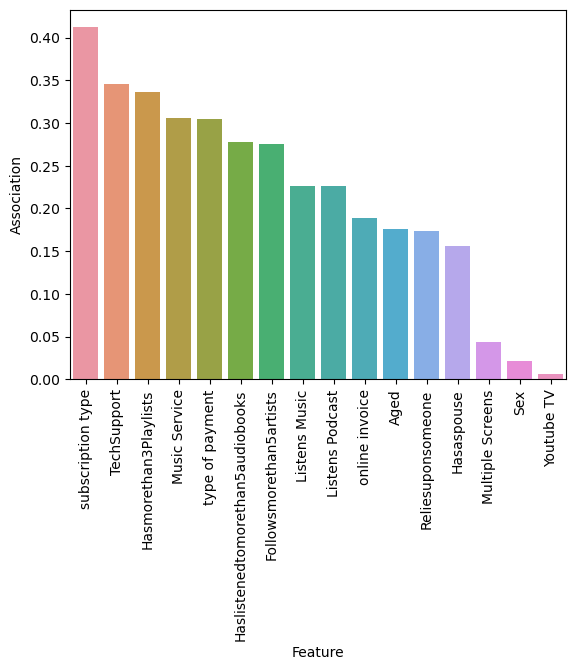

In [15]:
sns.barplot(x='Feature', y='Association', data=temp_df, order=temp_df.sort_values('Association', ascending=False)['Feature'])
plt.xticks(rotation=90)
plt.show()

In [16]:
# Filtering out weakly correlated categorical features
cat_features_df = temp_df.loc[temp_df['Association'] >= 0.20, :]

#### Association between binary response variable and numerical features (bivariate)

We see quite visible differences in each of the barplots between 'Yes' and 'No' in each feature. Each of the numerical features impacts the response variable.

##### We will use all our numerical features for our model

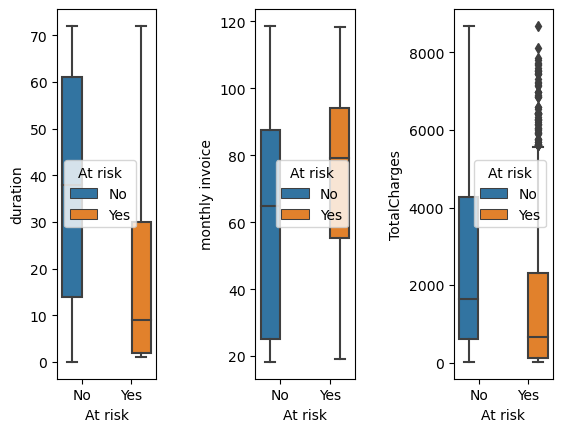

In [17]:
fig = plt.figure()
gs0 = pltgrid.GridSpec(1, 3, figure=fig, wspace=1)

ax1 = fig.add_subplot(gs0[0, 0])
ax2 = fig.add_subplot(gs0[0, 1])
ax3 = fig.add_subplot(gs0[0, 2])

sns.boxplot(data=train, x='At risk', y='duration', hue='At risk', ax=ax1)
sns.boxplot(data=train, x='At risk', y='monthly invoice', hue='At risk', ax=ax2)
sns.boxplot(data=train, x='At risk', y='TotalCharges', hue='At risk', ax=ax3)

plt.show()

## Exploring the response variable

We see that the binary response variable has an event rate of about 25%.

##### Let us consider using an oversampling technique to improve our results.

In [18]:
print(sum(y_train)/len(y_train)*100)

25.740551583248212


#### SMOTE for datasets with categorical features

##### We augment our training data using this technique

In [19]:
sm = SMOTENC(random_state=123, categorical_features=cat_features)

In [20]:
X_train, y_train = sm.fit_resample(train[features], y_train)

## Feature Engineering

We shall use one-hot encoding on our categorical features to convert them to indicator binary columns. We also scale our three numerical features. While this is NOT necessary for Decision Tree based algorithms, we go ahead nevertheless.

We also remove those categorical features with Cramer's V less than 0.20

In [21]:
ohe = OneHotEncoder()
cat_array = ohe.fit_transform(X_train[cat_features_df['Feature']]).toarray()

In [22]:
scaler = StandardScaler()
num_array = scaler.fit_transform(X_train[num_features])
X_train = pd.DataFrame(np.concatenate([cat_array, num_array], axis=1))

In [23]:
num_array = scaler.transform(test[num_features])
cat_array = ohe.transform(test[cat_features_df['Feature']]).toarray()
X_test = pd.DataFrame(np.concatenate([cat_array, num_array], axis=1))

In [24]:
feat_names = list(ohe.get_feature_names_out()) + num_features

In [25]:
X_train.columns = feat_names

## Model selection

We use the Random Forest algorithm to obtain predictions and feature importance.  Also, tree based models generally perform quite well on tabular data, so let us go ahead with RF. We start with Randomized Search to get a point estimate of our hyperparameters which will help us narrow our search during brute force Grid Search with CV.

#### Since we are dealing with customers at risk, we primarily focus on the recall metric.

##### Random Search

In [1180]:
param_grid = {
    'max_features': np.arange(start=0.1, stop=1.1, step=0.1),
    'max_depth': [3, 4, 5, 6, 7],
    'max_samples': np.arange(start=0.2, stop=1.2, step=0.2),
    'n_estimators': [50, 100, 200, 300, 500],
}

rf = RandomForestClassifier(bootstrap=True, random_state=123, n_jobs=-1)

rand_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions=param_grid, 
    cv = 3,
    n_jobs=-1,
    verbose=3,
    scoring='recall',
    n_iter=30,
)

rand_search.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=123),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_samples': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'n_estimators': [50, 100, 200, 300,
                                                         500]},
                   scoring='recall', verbose=3)

In [1181]:
rand_search.best_params_

{'n_estimators': 50, 'max_samples': 0.8, 'max_features': 0.1, 'max_depth': 5}

We will use the above as a point estimate to setup the grid for the grid search.

##### Grid search

In [1187]:
# param_grid chosen based on the results of the random search
param_grid = {
    'max_features': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'max_samples': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200],
}

rf = RandomForestClassifier(bootstrap=True, random_state=123, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid, 
    cv = 5,
    n_jobs=-1,
    verbose=3,
    scoring='recall',
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.1, 0.2, 0.3],
                         'max_samples': [0.7, 0.8, 0.9],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=3)

In [1211]:
# We will use choose these as our set of hyperparameters

grid_search.best_params_
# {'max_depth': 5, 'max_features': 0.1, 'max_samples': 0.8, 'n_estimators': 100}

{'max_depth': 5, 'max_features': 0.1, 'max_samples': 0.8, 'n_estimators': 100}

In [1212]:
rf = RandomForestClassifier(bootstrap=True, random_state=123354, n_jobs=-1, **grid_search.best_params_)

In [1213]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.1, max_samples=0.8,
                       n_jobs=-1, random_state=123354)

## Test performance

We see that the best chosen model has a recall of 0.73

In [1215]:
# We are mainly intereted in recall (how well does it perform specific to 1's in our data
# auc gives an idea of general performance

print('recall:', round(recall_score(y_test, rf.predict(X_test)), 2))
print('auc:', round(roc_auc_score(y_test, rf.predict(X_test)), 2))

recall: 0.73
auc: 0.75


## Feature importances

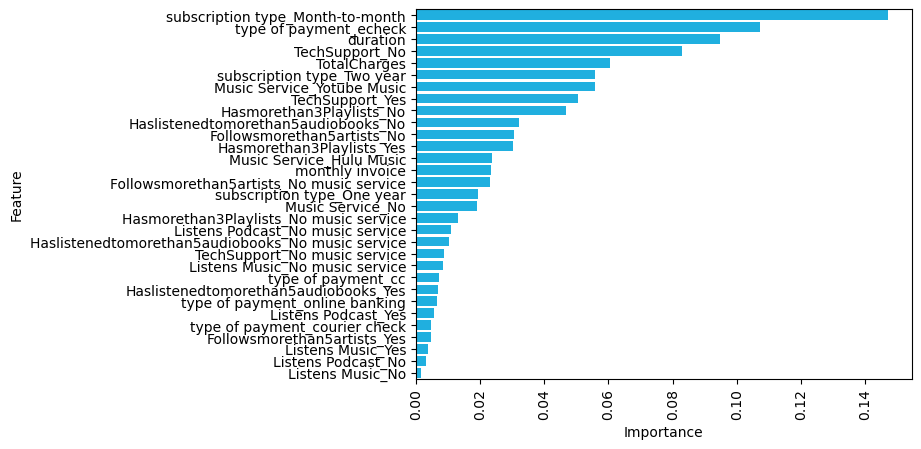

In [1317]:
# We plot the feature importances obtained from out RF model

temp_df = pd.DataFrame({'Importance':rf.feature_importances_, 'Feature':feat_names})

sns.barplot(x='Importance', y='Feature', data=temp_df, order=temp_df.sort_values('Importance', ascending=False)['Feature'], color='deepskyblue')
plt.xticks(rotation=90)
plt.show()

##### Inference

Let us extract the top 5 most important variables in our model. Let us construct a Logistic Regression model to find out what exactly the effects are for these top 5 variables.

In [1318]:
temp_df = temp_df.sort_values(by='Importance', ascending=False, na_position='last')

In [1319]:
select_feats = list(temp_df[0:5].loc[:, 'Feature'])

In [1320]:
lm = LogisticRegression(random_state=123).fit(X_train.loc[:, select_feats], y_train)

In [1324]:
print(lm.coef_, lm.intercept_)
print(select_feats)

[[ 1.46846462  1.06551426 -1.99962243  1.01070954  1.65476428]] [-2.39753449]
['subscription type_Month-to-month', 'type of payment_echeck', 'duration', 'TechSupport_No', 'TotalCharges']


From the signs of the coefficients above we infer the following:<br>
-> month-to-month subscribers at HIGHER risk<br>
-> those who pay using e-check are at HIGHER risk<br>
-> longer the duration, LOWER the risk<br>
-> those that did not opt for tech support are at HIGHER risk<br>
-> Higher the chargers HIGHER the risk<br>

Overall inference: Customers who are paying monthly probably are doing so because they know they do not want the plan long term. Those who pay more are at higher risk as they might decide to cut it out of their budget at some point.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Recall 

In [39]:
model = Sequential()
model.add(Dense(64, input_shape=(31, ), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Recall()])

In [41]:
model.fit(X_train, y_train, epochs=120, batch_size=15)

Epoch 1/150
582/582 [==============================] - 2s 1ms/step - loss: 0.5885 - recall: 0.8061
Epoch 2/150
582/582 [==============================] - 1s 1ms/step - loss: 0.4694 - recall: 0.8116
Epoch 3/150
582/582 [==============================] - 1s 1ms/step - loss: 0.4645 - recall: 0.8315
Epoch 4/150
582/582 [==============================] - 1s 2ms/step - loss: 0.4528 - recall: 0.8411
Epoch 5/150
582/582 [==============================] - 1s 1ms/step - loss: 0.4374 - recall: 0.8525
Epoch 6/150
582/582 [==============================] - 1s 1ms/step - loss: 0.4411 - recall: 0.8487
Epoch 7/150
582/582 [==============================] - 1s 1ms/step - loss: 0.4403 - recall: 0.8501
Epoch 8/150
582/582 [==============================] - 1s 2ms/step - loss: 0.4384 - recall: 0.8528
Epoch 9/150
582/582 [==============================] - 1s 1ms/step - loss: 0.4334 - recall: 0.8655
Epoch 10/150
582/582 [==============================] - 1s 2ms/step - loss: 0.4296 - recall: 0.8556
Epoch 11/

582/582 [==============================] - 1s 1ms/step - loss: 0.3537 - recall: 0.8624
Epoch 84/150
582/582 [==============================] - 1s 1ms/step - loss: 0.3593 - recall: 0.8649
Epoch 85/150
582/582 [==============================] - 1s 2ms/step - loss: 0.3620 - recall: 0.8528
Epoch 86/150
582/582 [==============================] - 1s 1ms/step - loss: 0.3582 - recall: 0.8631
Epoch 87/150
582/582 [==============================] - 1s 1ms/step - loss: 0.3607 - recall: 0.8652
Epoch 88/150
582/582 [==============================] - 1s 1ms/step - loss: 0.3557 - recall: 0.8676
Epoch 89/150
582/582 [==============================] - 1s 1ms/step - loss: 0.3591 - recall: 0.8649
Epoch 90/150
582/582 [==============================] - 1s 1ms/step - loss: 0.3550 - recall: 0.8673
Epoch 91/150
582/582 [==============================] - 1s 1ms/step - loss: 0.3589 - recall: 0.8638
Epoch 92/150
582/582 [==============================] - 1s 1ms/step - loss: 0.3606 - recall: 0.8514
Epoch 93/150


In [61]:
y_pred = model.predict_(X_test)

AttributeError: 'Sequential' object has no attribute 'predict_'

In [63]:
x = np.where(y_pred >= 0.5, 1, 0)

In [71]:
pd.Series(y_pred.flatten())

0      0.245413
1      0.032332
2      0.677292
3      0.289344
4      0.923260
         ...   
974    0.628175
975    0.031672
976    0.799510
977    0.777355
978    0.018248
Length: 979, dtype: float32

In [70]:
y_test

3912    0
1103    0
1222    1
2780    1
1855    1
       ..
296     0
4314    0
982     1
3993    1
93      0
Name: At risk, Length: 979, dtype: int64

In [87]:
def get_recall(y_test, y_pred, thresh):
    temp = pd.Series(y_pred.flatten())
    y_pred_class = temp.apply(lambda x: 1 if x >= thresh else 0)
    return round(recall_score(y_test, y_pred_class), 2)

In [89]:
a = np.arange(start=0.1, stop=0.9, step=0.05)

In [92]:
for i, value in enumerate(a):
    print(a[i], get_recall(y_test, y_pred, value))

0.1 0.87
0.15000000000000002 0.85
0.20000000000000004 0.83
0.25000000000000006 0.8
0.30000000000000004 0.73
0.3500000000000001 0.7
0.40000000000000013 0.68
0.45000000000000007 0.65
0.5000000000000001 0.64
0.5500000000000002 0.63
0.6000000000000002 0.6
0.6500000000000001 0.54
0.7000000000000002 0.5
0.7500000000000002 0.46
0.8000000000000002 0.4
0.8500000000000002 0.29


In [85]:
a

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85])

In [86]:
for count, value in enumerate(a):
    print(count, value)

0 0.1
1 0.15000000000000002
2 0.20000000000000004
3 0.25000000000000006
4 0.30000000000000004
5 0.3500000000000001
6 0.40000000000000013
7 0.45000000000000007
8 0.5000000000000001
9 0.5500000000000002
10 0.6000000000000002
11 0.6500000000000001
12 0.7000000000000002
13 0.7500000000000002
14 0.8000000000000002
15 0.8500000000000002
